In [12]:
### 데이터 및 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

train_file = '../data_final/Train_data.csv'
train_data = pd.read_csv(train_file)

In [13]:
### 모델 생성을 위한 Train 데이터 증강 by KNN
# scale_pv가 0이 아닌 데이터와 0인 데이터로 분리
non_zero_data = train_data[train_data['scale_pv'] != 0]
zero_data = train_data[train_data['scale_pv'] == 0]


# KNN을 위한 피처와 타겟 설정 (scale_pv가 0이 아닌 데이터)
features = non_zero_data.drop(columns=['scale_pv'])
target = non_zero_data['scale_pv']


# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_zero_features = scaler.transform(zero_data.drop(columns=['scale_pv']))


# KNN 모델 적합
knn = KNeighborsRegressor(n_neighbors=50) # 설정 이웃 수 2->1->5->10->100->50->25->50
knn.fit(scaled_features, target)


# 미측정 데이터에 대한 예측값 생성 (scale_pv가 0인 데이터, 소수점 아래 둘째자리까지)
predicted_scale_pv = np.round(knn.predict(scaled_zero_features), 2)


# 예측값을 미측정 데이터에 추가
zero_data.loc[:, 'scale_pv'] = predicted_scale_pv


# 원본 데이터와 새로 생성된 데이터를 결합하여 인덱스 기준으로 재정렬
augmented_data = pd.concat([non_zero_data, zero_data]).sort_index()
augmented_data = augmented_data.loc[train_data.index]

In [23]:
### 모델링 및  Train 평가
# 중복값 제거
augmented_data.drop_duplicates(inplace=True)


# 피처와 타겟 분리
X = augmented_data.drop(columns=['scale_pv'])
y = augmented_data['scale_pv']


# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.head())


# 모델 학습 및 평가 함수
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, scaler):
    model.fit(X_train, y_train)
    y_train_pred_scaled = model.predict(X_train)
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_train_original = scaler.inverse_transform(y_train.values.reshape(-1, 1))
    y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    
    train_mae = mean_absolute_error(y_train_original, y_train_pred)
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return train_mae, test_mae, train_mape, test_mape, y_train_pred, y_test_pred

# 타겟 스케일링
target_scaler = StandardScaler()
target_scaler.fit(target.values.reshape(-1, 1))


# Multiple Regression
lr_model = LinearRegression()
lr_train_mae, lr_test_mae, lr_train_mape, lr_test_mape, lr_y_train_pred, lr_y_test_pred = train_and_evaluate_model(lr_model, X_train, X_test, y_train, y_test, target_scaler)


# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_train_mae, rf_test_mae, rf_train_mape, rf_test_mape, rf_y_train_pred, rf_y_test_pred = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test, target_scaler)


# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_train_mae, lgb_test_mae, lgb_train_mape, lgb_test_mape, lgb_y_train_pred, lgb_y_test_pred = train_and_evaluate_model(lgb_model, X_train, X_test, y_train, y_test, target_scaler)


# 결과 출력
print(f"Linear Regression - Train MAE: {lr_train_mae}, Train MAPE: {lr_train_mape*100}")
print(f"Linear Regression - Test MAE: {lr_test_mae}, Test MAPE: {lr_test_mape*100}")
print()
print(f"Random Forest - Train MAE: {rf_train_mae}, Train MAPE: {rf_train_mape*100}")
print(f"Random Forest - Test MAE: {rf_test_mae}, Test MAPE: {rf_test_mape*100}")
print()
print(f"LightGBM - Train MAE: {lgb_train_mae}, Train MAPE: {lgb_train_mape*100}")
print(f"LightGBM - Test MAE: {lgb_test_mae}, Test MAPE: {lgb_test_mape*100}")


        c_temp_pv  k_rpm_pv  n_temp_pv  s_temp_pv
65696        70.3       180       66.8       67.6
123976       70.3       187       67.4       66.0
123631       70.4       182       68.0       67.8
174045       69.4       183       67.5       65.9
182387       69.4       174       66.5       67.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 104170, number of used features: 4
[LightGBM] [Info] Start training from score 3.043966
Linear Regression - Train MAE: 0.0005044547973532573, Train MAPE: 0.01596356110706408
Linear Regression - Test MAE: 0.0005078379969068374, Test MAPE: 0.016070703792725342

Random Forest - Train MAE: 0.0001938693702128471, Train MAPE: 0.0061351142402616445
Random Forest - Test MAE: 0.00041560089

In [15]:
### Test 평가
test_file = '../data_final/Test_data.csv'
test_data = pd.read_csv(test_file)


# scale_pv 값이 2초과 4미만인 데이터 선택
test_data_filtered = test_data[(test_data['scale_pv'] > 2) & (test_data['scale_pv'] < 4)]


# 피처와 타겟 분리
X_test_final = test_data_filtered.drop(columns=['scale_pv'])
y_test_final = test_data_filtered['scale_pv']


# 최종 테스트 데이터 예측 및 평가
def final_evaluate_model(model, X_test, y_test, scaler):
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return test_mae, test_mape, y_test_pred


# 최종 평가 결과
lr_test_mae_final, lr_test_mape_final, lr_y_test_pred_final = final_evaluate_model(lr_model, X_test_final, y_test_final, target_scaler)
rf_test_mae_final, rf_test_mape_final, rf_y_test_pred_final = final_evaluate_model(rf_model, X_test_final, y_test_final, target_scaler)
lgb_test_mae_final, lgb_test_mape_final, lgb_y_test_pred_final = final_evaluate_model(lgb_model, X_test_final, y_test_final, target_scaler)

print(f"Final Test - Linear Regression MAE: {lr_test_mae_final}, MAPE: {lr_test_mape_final*100}")
print(f"Final Test - Random Forest MAE: {rf_test_mae_final}, MAPE: {rf_test_mape_final*100}")
print(f"Final Test - LightGBM MAE: {lgb_test_mae_final}, MAPE: {lgb_test_mape_final*100}")

Final Test - Linear Regression MAE: 0.0009103039918948051, MAPE: 0.02880019210423469
Final Test - Random Forest MAE: 0.0010451038655071077, MAPE: 0.03306669498185942
Final Test - LightGBM MAE: 0.0009440230667424337, MAPE: 0.02986812973042499


In [16]:
# Save the prediction
final_data = test_data_filtered.copy()
final_data['lr_pred'] = lr_y_test_pred_final
# Loss 값도 추가
final_data['lr_loss'] = final_data['scale_pv'] - final_data['lr_pred']
final_data['rf_pred'] = rf_y_test_pred_final
final_data['rf_loss'] = final_data['scale_pv'] - final_data['rf_pred']
final_data['lgb_pred'] = lgb_y_test_pred_final
final_data['lgb_loss'] = final_data['scale_pv'] - final_data['lgb_pred']

final_data.to_csv('../data_final//final_data.csv', index=False)

In [17]:
final_data.describe()

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv,lr_pred,lr_loss,rf_pred,rf_loss,lgb_pred,lgb_loss
count,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000
mean,69.762349,187.269751,67.540214,3.047580,67.409181,3.159935,-0.112355,3.160022,-0.112442,3.160004,-0.112424
std,0.351653,5.790426,0.929310,0.032548,1.110989,0.000291,0.032460,0.000774,0.032446,0.000522,0.032454
min,68.600000,144.000000,66.100000,2.850000,65.400000,3.159430,-0.309824,3.155455,-0.310468,3.155135,-0.310679
25%,69.500000,187.000000,66.800000,3.030000,66.500000,3.159765,-0.129901,3.159569,-0.130192,3.159739,-0.129954
50%,69.700000,188.000000,67.300000,3.050000,67.300000,3.159862,-0.110034,3.159902,-0.110484,3.159844,-0.110253
75%,70.000000,189.000000,68.000000,3.060000,68.200000,3.160001,-0.099732,3.160398,-0.099335,3.160104,-0.099675
max,70.700000,202.000000,70.600000,3.280000,71.100000,3.161496,0.119195,3.163964,0.117293,3.163422,0.118156


c:\Users\wjs31\.conda\envs\EXAM_MML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


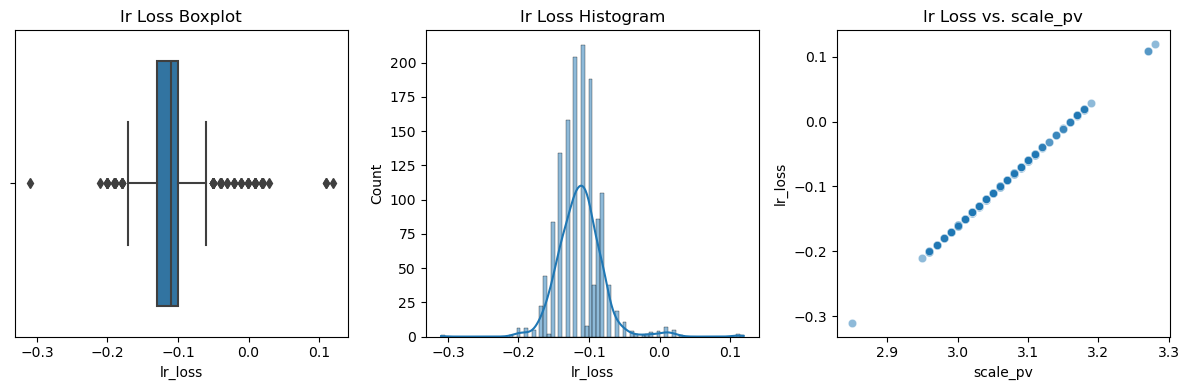

c:\Users\wjs31\.conda\envs\EXAM_MML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


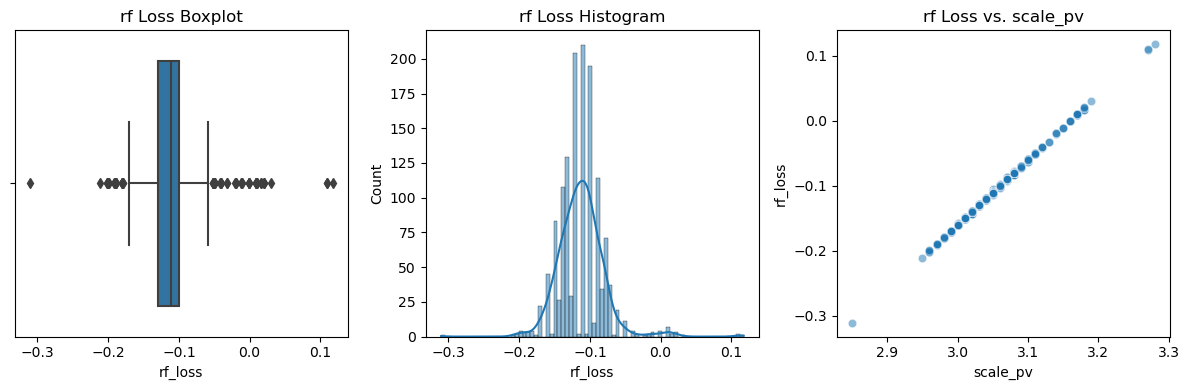

c:\Users\wjs31\.conda\envs\EXAM_MML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


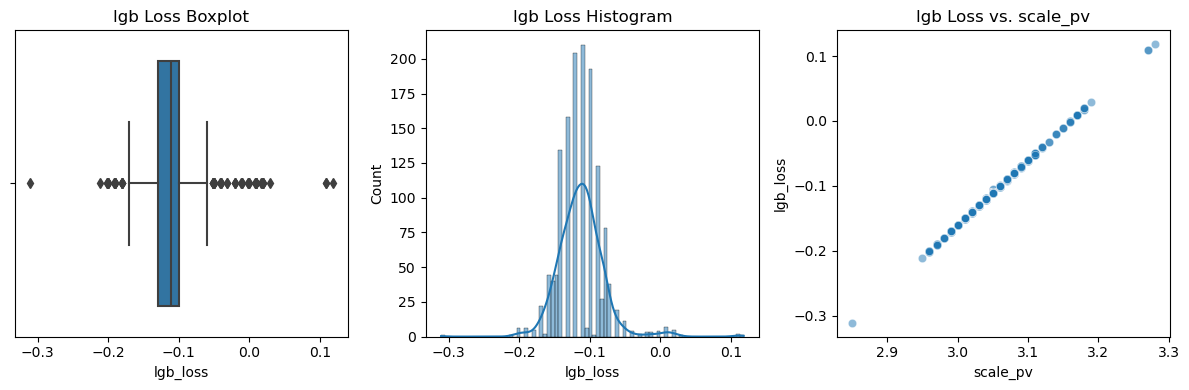

In [18]:
# _loss 로 끝나는 컬럼들의 boxplot, histogram, scatter plot

for model in ['lr', 'rf', 'lgb']:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.boxplot(data=final_data, x=f'{model}_loss')
    plt.title(f'{model} Loss Boxplot')
    
    plt.subplot(1, 3, 2)
    sns.histplot(data=final_data, x=f'{model}_loss', kde=True)
    plt.title(f'{model} Loss Histogram')
    
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=final_data, x='scale_pv', y=f'{model}_loss', alpha=0.5)
    plt.title(f'{model} Loss vs. scale_pv')
    
    plt.tight_layout()
    plt.show()

In [19]:
# lr_loss 기준 정렬
final_data.sort_values(by='lr_loss', ascending=False)[['scale_pv', 'lr_pred', 'lr_loss']].head(10)

,scale_pv,lr_pred,lr_loss
14507,3.28,3.160805,0.119195
22174,3.27,3.160626,0.109374
22173,3.27,3.160654,0.109346
21909,3.19,3.160988,0.029012
22241,3.18,3.160180,0.019820
22240,3.18,3.160222,0.019778
14520,3.18,3.160539,0.019461
6432,3.18,3.161477,0.018523
6431,3.18,3.161496,0.018504
22352,3.17,3.160308,0.009692


In [20]:
# 음수 정렬
final_data.sort_values(by='lr_loss', ascending=True)[['scale_pv', 'lr_pred', 'lr_loss']].head(10)

,scale_pv,lr_pred,lr_loss
11054,2.85,3.159824,-0.309824
1294,2.95,3.160551,-0.210551
12231,2.96,3.161087,-0.201087
12232,2.96,3.161069,-0.201069
6866,2.96,3.160356,-0.200356
6865,2.96,3.160304,-0.200304
12487,2.96,3.160149,-0.200149
12486,2.96,3.160100,-0.200100
27965,2.97,3.160158,-0.190158
27964,2.97,3.160106,-0.190106


In [21]:
# Save Model
import joblib

joblib.dump(lr_model, '../model/lr_model.pkl')
# scaler 저장
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']